# <center>Centro Universitário Facens<br/></center>
<br/>
<font size="4"><center><b>Disciplina: Processamento de imagens</b></center></font>
  
<font size="3"><center>Prof. Renato M. Silva</center></font>
<br/>
<br/>

## <center>Avaliação Continuada 2 (AC2)</center>

----
### <center>Nome e RA dos componentes do grupo</center>

    
| Nome     |      RA      | 
|:-        |:-------------:|
|Marcelo Zaguette Junior          | 180998               | 
|Michel Micheloti          |181003              | 
|Fernando Dias Motta          |              | 
|          |              | 
    

----
### Instruções
**1**. Siga boas práticas de programação:
- dar nomes intuitivos para as variáveis
- dar nomes intuitivos para as funções


**2**. O trabalho pode ser feito em grupos de até 5 pessoas, contendo alunos de qualquer uma das turmas da disciplina (CP405TIN1 e CP405TIN2). Apenas uma pessoa do grupo deve submeter o trabalho. Você deve submeter apenas o arquivo .ipynb.

**3**. Cuidado com plágio. Se for detectado plágio entre grupos, a punição será dada para todos os componentes dos grupos envolvidos.

**4**. Antes de submeter o notebook, certifique-se que não há erros de código. Uma forma de se certificar disso é usar a opção **"Reiniciar Kernel e executar todas as células"** do Jupyter ou a opção **"Reiniciar e executar tudo"** do Google Colab. 

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image 

----
## Exercício 1

Implemente uma função que troque os quadrantes em diagonal na imagem e aplique na imagem **figs/lena.jpg**, conforme o primeiro exemplo abaixo. Em seguida, adicione a imagem **figs/facens.png** na imagem resultante, conforme mostrado no segundo exemplo abaixo. Por fim, mostre a imagem na tela.

**Dica**: para remover o fundo da imagem **figs/facens.png**, você pode usar um algoritmo de segmentação, como por exemplo a limiarização. 

<center>
<div style="display:inline-block;">
    <div>
    <div style="padding: 5px; float: left;">
        <img src="imgNotebook/LenaQuadrantes.jpg" width="255" height="128" />
    </div>
    <div style="padding: 5px; float: left;">
        <img src="imgNotebook/LenaFacens.jpg" width="255" height="128" />
    </div>   
</div> 
</center>

512
512


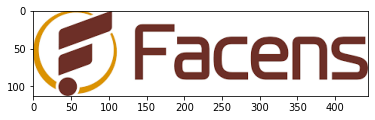

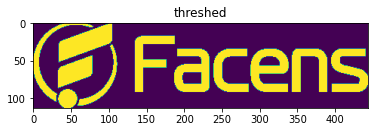

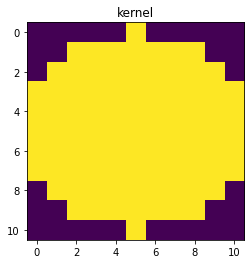

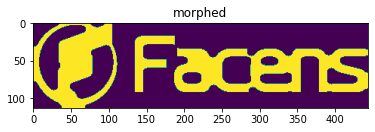

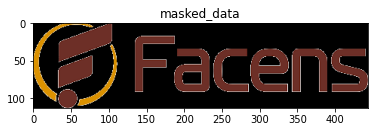

113
444


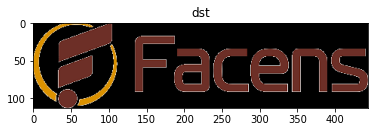

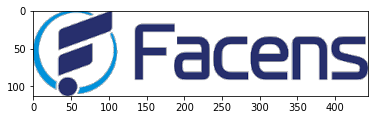

In [27]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    plt.imshow(threshed)
    plt.title("threshed")
    plt.show()

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    plt.imshow(kernel)
    plt.title("kernel")
    plt.show()

    plt.imshow(morphed)
    plt.title("morphed")
    plt.show()


    cnts = cv2.findContours(morphed, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[0]

    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    plt.imshow(masked_data)
    plt.title("masked_data")
    plt.show()

    dimensionsMaskedData = masked_data.shape
    print(dimensionsMaskedData[0])
    print(dimensionsMaskedData[1])

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[0: 113, 0: 444]

    plt.imshow(dst)
    plt.title("dst")
    plt.show()


    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)

    return dst

initialImage = cv2.imread("figs/lena.jpg")
lenaImageRGB = cv2.cvtColor(initialImage, cv2.COLOR_BGR2RGB)
lenaImage = cv2.cvtColor(lenaImageRGB, cv2.COLOR_BGR2GRAY)
cv2.imwrite('lenaImageGray.png', lenaImage)
dimensionsLena = lenaImage.shape
print(dimensionsLena[0])
print(dimensionsLena[1])
crop_img_quad1 = lenaImage[0:256, 256:512]
crop_img_quad2 = lenaImage[0:256, 0:256]
crop_img_quad3 = lenaImage[256:512, 0:256]
crop_img_quad4 = lenaImage[256:512, 256:512]
visVertical1 = np.concatenate((crop_img_quad4,crop_img_quad3), axis=0)
visVertical2 = np.concatenate((crop_img_quad1,crop_img_quad2), axis=0)
reorganizedImage = np.concatenate((visVertical1,visVertical2), axis=1)
cv2.imwrite('reorganizedImageLena.png', reorganizedImage)
reorganizedImage = cv2.imread("reorganizedImageLena.png")
# plt.imshow(reorganizedImage)

facensLogo = cv2.imread('figs/facens.png')

plt.imshow(facensLogo)
plt.show()

noBackgroud = remove_background(facensLogo, threshold=250.)

cv2.imwrite("noBackgroundTest.png",noBackgroud)

plt.imshow(noBackgroud)
plt.show()

----
## Exercício 2

Implemente uma função que consiga fazer a detecção de movimentos em um vídeo. Ela deverá extrair os frames do vídeo e para cada frame, ele deve calcular o histograma da imagem e compará-lo com o último histograma calculado. Quando a diferença entre estes ultrapassar um limiar pré-estabelecido, simule um alarme interrompendo a função e retornando uma mensagem de alerta. Utilize uma função de comparação que julgar conveniente. 

Teste a função no vídeo *videos/cameraEscondida.mp4*.

In [3]:
##### Resolva o exercício aqui


----
## Exercicio 3

Por meio de operações morfológicas e outras técnicas aprendidas na disciplina, destaque o arroz da imagem **figs/arroz.tif**. Você deve salvar a nova imagem com o nome **arroz_destacado.jpg**. Abaixo é mostrado um exemplo do resultado esperado.

<img src="imgNotebook/arroz.png" width="410" height="128" />

In [4]:
##### Resolva o exercício aqui



----
## Exercicio 4

Remova o ruído das imagens **figs/casa.png** e **figs/placa.tif**. Depois, mostre a imagem restaurada na tela.

In [5]:
##### Resolva o exercício aqui



----
## Exercicio 5

Utilize operações morfológicas nas imagens **figs/manequim.png** e **figs/tabuleiro.jpg** para remover os pontos brancos. Depois, mostre as imagens restauradas na tela.

In [6]:
##### Resolva o exercício aqui



----
## Exercicio 6

Por meio de operações morfológicas, remova o círculos menores da imagem **figs/circulos.tif**, deixando apenas os círculos maiores. 

In [7]:
##### Resolva o exercício aqui



----
## Exercicio 7

Aplique um filtro Gaussiano na imagem **figs/lena_noise.png** para diminuir o ruído e mostre na tela. Depois, faça a detecção de bordas da imagem resultante usando as seguintes técnicas: Sobel, Prewitt e Frei-Chen. Mostre na tela os resultado obtido após cada uma das técnicas de detecção de bordas.

In [8]:
##### Resolva o exercício aqui


----
## Exercicio 8

Por meio das técnicas aprendidas na disciplina, tente melhorar o **máximo** possível a imagem **figs/lena_pontilhada.png**. 

In [9]:
##### Resolva o exercício aqui


----
## Exercicio 9

Aplique um filtro para borrar as extremidades da imagem **figs/vista.jpg** para que ela fique com o efeito mostrado na imagem abaixo.

<img src="imgNotebook/vista_blur.jpg" width="500" height="128" />

In [10]:
##### Resolva o exercício aqui


----
## Exercicio 10

As imagens **Degraded_A.jpg** e **Degraded_B.jpg** possuem algum grau de degradação. Melhore a qualidade dessas imagens com as técnicas aprendidas na disciplina e mostre o resultado na tela. O resultado final deve ser o mais próximo possível da imagem original mostrada abaixo. 

<img src="imgNotebook/Desired.jpg" width="250" />